# Estimation of basal enzymes concentrations in donor hearts from Copeland et al. 2010 data (https://doi.org/10.1016/j.yjmcc.2010.09.007)

This notebook performs the paramter estimation procedure for the results shown in Figure 4A,B and Figures S22 of the publication:

Thomas Kampourakis, Saraswathi Ponnam, Daniel Koch (2023):
The cardiac myosin binding protein-C phosphorylation state as a function of multiple protein kinase and phosphatase activities 
Preprint available under: https://doi.org/10.1101/2023.02.24.529959 

Note that the files '**cMyBPC_FinalModelCopelandDonors.cps**'' and '**copeland2010_donor.csv**' are required to be in the same folder as this notebook and that the file '**parametersets\paramset_final.npy** needs to be in the parent folder. 

The final figures in the paper are generated by the script '**data_analysis_Copeland_and_optimization.py**'.

### **Step 0**: load packages, define boundaries and initial guesses for parameter estimates, define settings for parameter estimation algorithms.

In [1]:
from basico import *
import sys
%pylab
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
if not '../..' in sys.path:
    sys.path.append('../..')
    
import os
fileDirectory = os.path.abspath('')
path_paramsets = os.path.join(os.path.split(fileDirectory)[0], 'parametersets') 

# Load fitted parametersets for PKA, PP1, PP2A
paramset = np.load(os.path.join(path_paramsets, 'paramset_final.npy'))
load_model('cMyBPC_FinalModel_CopelandDonors.cps')

# Add measured PKC params
pkc_Kms = np.linspace(3.167e-6,	7.537e-6,4)
pkc_kcat = (5.053+5.262)/2
paramset[:,42] = pkc_Kms[0]
paramset[:,45] = pkc_Kms[1]
paramset[:,48] = pkc_Kms[2]
paramset[:,51] = pkc_Kms[3]
paramset[:,[12,15,18,21]] = pkc_kcat


print(get_parameters())
    
low_up_bnd = [[5e-10, 5e-7],  #PKA
              [0,2e-7],      #PKC
              [1e-10,1e-6],  #PP1
              [1e-10,1e-6],   #total Phosphatases
              [0,2e-7]       #RSK2
             ]
startVal =   [1e-8, 1e-8, 1e-8, 2e-8, 1e-9] #PKA, PKC, PP1, total Phosphatases, RSK2 

#Settings for parameter estimation algorithms
settingsHJ = {'method': {'name': PE.HOOKE_JEEVES, 'Iteration Limit':50,'Tolerance':1e-05, 'Rho':0.2}}

Using matplotlib backend: <object object at 0x0000016B94FC1A90>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
                 type unit  initial_value initial_expression  \
name                                                           
TOT        assignment            0.000020                      
3P_rel     assignment            0.000000                      
A_rel      assignment            0.000000                      
AB_rel     assignment            0.000000                      
ABC_rel    assignment            0.000000                      
...               ...  ...            ...                ...   
AX_rel     assignment            0.000000                      
ABX_rel    assignment            0.000000                      
ABCX_rel   assignment            0.000000                      
PPase_tot       fixed            0.000000                      
quantity        fixed    

In [2]:
# Parameter names in Copasi model which are not to be estimated
paramNames = []
for i in range(1,31):
    paramNames.append('k'+str(i))
for i in range(1,31):
    paramNames.append('K'+str(i))
    
p_app = ['k2f','K2f','kisoF','kisoR','k3f','K3f']
for s in p_app: paramNames.append(s)

print(paramNames)

['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k12', 'k13', 'k14', 'k15', 'k16', 'k17', 'k18', 'k19', 'k20', 'k21', 'k22', 'k23', 'k24', 'k25', 'k26', 'k27', 'k28', 'k29', 'k30', 'K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'K10', 'K11', 'K12', 'K13', 'K14', 'K15', 'K16', 'K17', 'K18', 'K19', 'K20', 'K21', 'K22', 'K23', 'K24', 'K25', 'K26', 'K27', 'K28', 'K29', 'K30', 'k2f', 'K2f', 'kisoF', 'kisoR', 'k3f', 'K3f']


### **Step 1**: define which parameters to estimate and range for estimates etc

In [3]:
#Defining which parameters to estimate and setting boundaries and start values
vNames_cps = [
             'Values[PKA].InitialValue',
             'Values[PKC].InitialValue',
             'Values[PP1].InitialValue',
             'Values[PPase_tot].InitialValue',
             'Values[RSK2].InitialValue',]

fit_items = []
for i in range(len(vNames_cps)):
    fit_items.append({'name': vNames_cps[i], 'lower': low_up_bnd[i][0], 'upper': low_up_bnd[i][1], 'start': startVal[i]})


set_fit_parameters(fit_items)

#Show settings for fitting parameters
get_fit_parameters()

,lower,upper,start,affected,cn
name,,,,,
Values[PKA],5e-10,5e-07,1.000000e-08,[],"CN=Root,Model=New Model,Vector=Values[PKA],Ref..."
Values[PKC],0.0,2e-07,1.000000e-08,[],"CN=Root,Model=New Model,Vector=Values[PKC],Ref..."
Values[PP1],1e-10,1e-06,1.000000e-08,[],"CN=Root,Model=New Model,Vector=Values[PP1],Ref..."
Values[PPase_tot],1e-10,1e-06,2.000000e-08,[],"CN=Root,Model=New Model,Vector=Values[PPase_to..."
Values[RSK2],0.0,2e-07,1.000000e-09,[],"CN=Root,Model=New Model,Vector=Values[RSK2],Re..."


### **Step 2**: local search using Hooke & Jeeves algorithm

In [6]:
from tqdm import tqdm

result = np.array([])
fitValsDonor = np.array([])

nruns = paramset.shape[0] # number of parameter runs to be performed

#set RSK2 params (same for all paramsets)
set_parameters(name= 'k31', initial_value = 1.8, value = 1.8)
set_parameters(name= 'k32', initial_value = 1.8, value = 1.8)
set_parameters(name= 'K31', initial_value = 1.3e-6, value = 1.3e-6)
set_parameters(name= 'K32', initial_value = 1.3e-6, value = 1.3e-6)

for i in tqdm(range(0,nruns)):
    
    #set other parameters fitted previously
    for pn in range(len(paramNames)):
                set_parameters(name= paramNames[pn], initial_value = paramset[i,2+pn], value = paramset[i,2+pn])
    
    # fit enzyme concentrations (PKA, PKC, etc...)
    n = 0
    while n < 5:
        try:
            currentParams = run_parameter_estimation(settings=settingsHJ, update_model=True)
            estimates = np.array(currentParams['sol']) # estimates for parameters
            stats = get_fit_statistic(solution=currentParams)
            exp, sim = get_simulation_results(solution=currentParams)
            objFval = np.array(stats['obj']) # value of the objective function
            
            # Fill the result matrix:
            # if first run, generate horizontal array with run nr., objFunc value and resulting parameters to fill first row
            # if i-th run, perform vertical concatenation to fill i-th row
            if len(result) > 0: 
                result = np.vstack((result, np.hstack((np.array([i]), objFval, estimates))))
                fitValsDonor = np.vstack((fitValsDonor, np.asarray(sim[0])))
            else:
                result = np.hstack((np.array([i]), objFval, estimates))
                fitValsDonor = np.asarray(sim[0])
            n=5
            
        except:
            print('numerical error - trying again...')
            n = n + 1

np.save('fittedEnzymeConcentrations_Copeland_DonorHearts.npy',result)  
np.save('fittedMyBPCstates_Copeland_DonorHearts.npy',fitValsDonor)  

100%|██████████| 35/35 [03:03<00:00,  5.25s/it]


## plot data

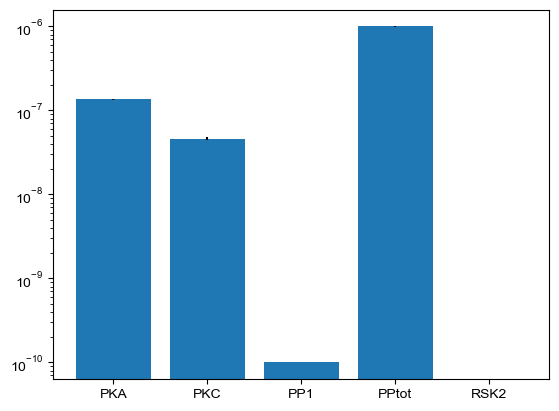

(-0.05, 1.05)

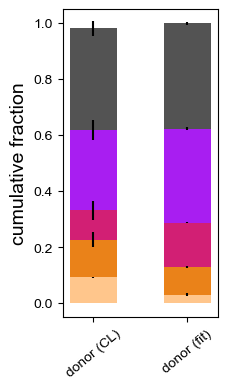

In [7]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.family':'Arial'})

means_donor_fit = np.mean(fitValsDonor,axis=0)
SEMs_donor_fit = np.std(fitValsDonor,axis=0)/np.sqrt(nruns)

plt.bar(np.asarray(range(5)), np.mean(result[:,2:],axis=0),yerr=np.std(result[:,2:],axis=0)/np.sqrt(nruns))
plt.yscale('log')
plt.xticks(np.asarray(range(5)),['PKA','PKC','PP1','PPtot','RSK2'])
plt.show()

####### Experimental data from Copeland et al. 2010  ###########      
nsamples_donor = 21
means_donor = np.array([0.093, 0.134, 0.105, 0.287, 0.364])
SEMs_donor = np.array([0.001, 0.027, 0.033, 0.037, 0.027])
SDs_donor = SEMs_donor*np.sqrt(nsamples_donor)
###############################################################
 
c4P_2 =  (0.25,0.25,0.25) 
c3P =  (159/255, 5/255, 240/255) 
c2P =  (206/255, 6/255, 101/255) 
c1P =  (232/255, 116/255, 0/255) 
c0P =  (255/255, 192/255, 128/255) 
colors = [c0P,c1P,c2P,c3P,c4P_2]
pstates = ['0P','1P','2P','3P','4P']
width = 0.5
fig, ax = plt.subplots(figsize=(2,4))

btm_donor = 0
btm_donor_fit = 0

for i in range(5):
    ax.bar(1, means_donor[i], width, yerr=SEMs_donor[i], bottom=btm_donor,color = colors[i],alpha=0.9)
    ax.bar(2, means_donor_fit[i], width, yerr=SEMs_donor_fit[i], bottom=btm_donor_fit,color = colors[i],alpha=0.9)
    btm_donor = btm_donor + means_donor[i]
    btm_donor_fit = btm_donor_fit + means_donor_fit[i]
        
ax.set_xticks([1,2])
ax.set_xticklabels(['donor (CL)','donor (fit)'],rotation=40)
ax.set_ylabel('cumulative fraction',fontsize=14)
ax.set_ylim(-0.05,1.05)

In [8]:
print('average of fitted enzyme concentrations to donor data:')
enzymeNames = ['PKA','PKC','PP1','PPtot','RSK2']
for i in range(5):
    print(enzymeNames[i],': ', np.mean(result[:,2+i],axis=0))
print('PKA/PPtot:',np.mean(result[:,0+2])/np.mean(result[:,3+2]))

average of fitted enzyme concentrations to donor data:
PKA :  1.3613242606947515e-07
PKC :  4.630412810803833e-08
PP1 :  1e-10
PPtot :  9.995172571428523e-07
RSK2 :  0.0
PKA/PPtot: 0.13619817476549975


### Predicted HF Situation

In [9]:
reductionPKA = 0.5
increasePP1 = 2
increasePP2A = 2
increasePPtot = (increasePP1 + increasePP2A)/2

In [10]:
valsHF_predicted = []
nruns = paramset.shape[0] # number of parameter runs to be performed

#set RSK2 params (same for all paramsets)
set_parameters(name= 'k31', initial_value = 1.8, value = 1.8)
set_parameters(name= 'k32', initial_value = 1.8, value = 1.8)
set_parameters(name= 'K31', initial_value = 1.3e-6, value = 1.3e-6)
set_parameters(name= 'K32', initial_value = 1.3e-6, value = 1.3e-6)

for i in tqdm(range(0,nruns)):
    
    #set other parameters fitted previously
    for pn in range(len(paramNames)):
                set_parameters(name= paramNames[pn], initial_value = paramset[i,2+pn], value = paramset[i,2+pn])
            
    set_parameters(name= 'PKA', initial_value = result[i,2]*reductionPKA, value = result[i,2]*reductionPKA)
    set_parameters(name= 'PKC', initial_value = result[i,3], value = result[i,3])
    set_parameters(name= 'PP1', initial_value = result[i,4]*increasePP1, value = result[i,4]*increasePP1)
    set_parameters(name= 'PPase_tot', initial_value = result[i,5]*increasePPtot, value = result[i,5]*increasePPtot)
    set_parameters(name= 'RSK2', initial_value = result[i,6], value = result[i,6])
    
    run_steadystate()
    conc_SS = np.asarray(get_species().loc[: , "concentration"]) 
    
    rel_0P = conc_SS[2]/np.sum(conc_SS)
    rel_1P = (conc_SS[4]+conc_SS[6]+conc_SS[7])/np.sum(conc_SS)
    rel_2P = (conc_SS[0]+conc_SS[1])/np.sum(conc_SS)
    rel_3P = (conc_SS[3]+conc_SS[5])/np.sum(conc_SS)
    rel_4P = conc_SS[8]/np.sum(conc_SS)
    valsHF_predicted.append(rel_0P)
    valsHF_predicted.append(rel_1P)
    valsHF_predicted.append(rel_2P)
    valsHF_predicted.append(rel_3P)
    valsHF_predicted.append(rel_4P)
    
valsHF_predicted = np.asarray(valsHF_predicted)
valsHF_predicted = np.reshape(valsHF_predicted,(nruns,5))

np.save('predictedMyBPCstates_Copeland_FailingHearts.npy',valsHF_predicted)  

100%|██████████| 35/35 [00:53<00:00,  1.54s/it]


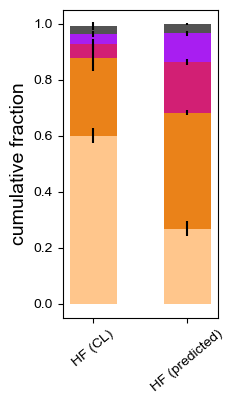

In [11]:
means_HF_fit = np.mean(valsHF_predicted,axis=0)
SEMs_HF_fit = np.std(valsHF_predicted,axis=0)/np.sqrt(nruns)

####### Experimental data from Copeland et al. 2010  ###########      
nsamples_HF = 19
means_HF = np.array([0.601,0.278,0.048,0.037,0.028])
SEMs_HF = np.array([0.028,0.048,0.02,0.012,0.013])
SDs_HF = SEMs_HF*np.sqrt(nsamples_HF)
###############################################################
c4P_2 =  (0.25,0.25,0.25) 
c3P =  (159/255, 5/255, 240/255) 
c2P =  (206/255, 6/255, 101/255) 
c1P =  (232/255, 116/255, 0/255) 
c0P =  (255/255, 192/255, 128/255) 
colors = [c0P,c1P,c2P,c3P,c4P_2]
pstates = ['0P','1P','2P','3P','4P']
width = 0.5
fig, ax = plt.subplots(figsize=(2,4))

btm_HF = 0
btm_HF_fit = 0

for i in range(5):
    ax.bar(1, means_HF[i], width, yerr=SEMs_HF[i], bottom=btm_HF,color = colors[i],alpha=0.9)
    ax.bar(2, means_HF_fit[i], width, yerr=SEMs_HF_fit[i], bottom=btm_HF_fit,color = colors[i],alpha=0.9)
    btm_HF = btm_HF + means_HF[i]
    btm_HF_fit = btm_HF_fit + means_HF_fit[i]
        
ax.set_xticks([1,2])
ax.set_xticklabels(['HF (CL)','HF (predicted)'],rotation=40)
ax.set_ylabel('cumulative fraction',fontsize=14)
ax.set_ylim(-0.05,1.05)
plt.savefig('HFpredicted_Copeland_vs_model.png',dpi=300, bbox_inches = "tight")

## Control experiment: fitting donor heart data with PP1 only (Figure S22)

### **Step 1**: define which parameters to estimate and range for estimates etc

In [13]:
low_up_bnd = [[5e-10, 5e-7],  #PKA
              [0,2e-7],      #PKC
              [1e-6,1e-6],  #PP1
              [1e-6,1e-6],   #total Phosphatases
              [0,2e-7]       #RSK2
             ]

startVal =   [1e-8, 1e-8, 1e-6, 1e-6, 1e-9] #PKA, PKC, PP1, total Phosphatases, RSK2 

fit_items = []
for i in range(len(vNames_cps)):
    fit_items.append({'name': vNames_cps[i], 'lower': low_up_bnd[i][0], 'upper': low_up_bnd[i][1], 'start': startVal[i]})


set_fit_parameters(fit_items)

#Show settings for fitting parameters
get_fit_parameters()

,lower,upper,start,affected,cn
name,,,,,
Values[PKA],5e-10,5e-07,1.000000e-08,[],"CN=Root,Model=New Model,Vector=Values[PKA],Ref..."
Values[PKC],0.0,2e-07,1.000000e-08,[],"CN=Root,Model=New Model,Vector=Values[PKC],Ref..."
Values[PP1],1e-06,1e-06,1.000000e-06,[],"CN=Root,Model=New Model,Vector=Values[PP1],Ref..."
Values[PPase_tot],1e-06,1e-06,1.000000e-06,[],"CN=Root,Model=New Model,Vector=Values[PPase_to..."
Values[RSK2],0.0,2e-07,1.000000e-09,[],"CN=Root,Model=New Model,Vector=Values[RSK2],Re..."


### Step 2: local search using Hooke & Jeeves algorithm

In [14]:
from tqdm import tqdm

result = np.array([])
fitValsDonor = np.array([])

nruns = paramset.shape[0] # number of parameter runs to be performed

#set RSK2 params (same for all paramsets)
set_parameters(name= 'k31', initial_value = 1.8, value = 1.8)
set_parameters(name= 'k32', initial_value = 1.8, value = 1.8)
set_parameters(name= 'K31', initial_value = 1.3e-6, value = 1.3e-6)
set_parameters(name= 'K32', initial_value = 1.3e-6, value = 1.3e-6)

for i in tqdm(range(0,nruns)):
    
    #set other parameters fitted previously
    for pn in range(len(paramNames)):
                set_parameters(name= paramNames[pn], initial_value = paramset[i,2+pn], value = paramset[i,2+pn])
    
    # fit enzyme concentrations (PKA, PKC, etc...)
    n = 0
    while n < 5:
        try:
            currentParams = run_parameter_estimation(settings=settingsHJ, update_model=True)
            estimates = np.array(currentParams['sol']) # estimates for parameters
            stats = get_fit_statistic(solution=currentParams)
            exp, sim = get_simulation_results(solution=currentParams)
            objFval = np.array(stats['obj']) # value of the objective function
            
            # Fill the result matrix:
            # if first run, generate horizontal array with run nr., objFunc value and resulting parameters to fill first row
            # if i-th run, perform vertical concatenation to fill i-th row
            if len(result) > 0: 
                result = np.vstack((result, np.hstack((np.array([i]), objFval, estimates))))
                fitValsDonor = np.vstack((fitValsDonor, np.asarray(sim[0])))
            else:
                result = np.hstack((np.array([i]), objFval, estimates))
                fitValsDonor = np.asarray(sim[0])
            n=5
            
        except:
            print('numerical error - trying again...')
            n = n + 1

np.save('fittedMyBPCstates_Copeland_DonorHearts_ctrl.npy',fitValsDonor)  

100%|██████████| 35/35 [02:15<00:00,  3.88s/it]


## plot data

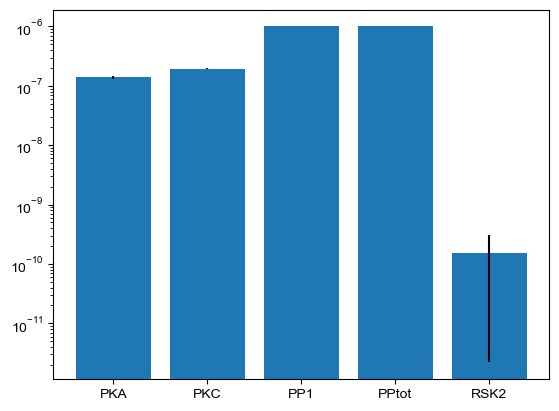

(-0.05, 1.05)

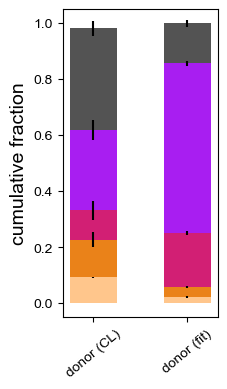

In [15]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.family':'Arial'})

means_donor_fit = np.mean(fitValsDonor,axis=0)
SEMs_donor_fit = np.std(fitValsDonor,axis=0)/np.sqrt(nruns)

plt.bar(np.asarray(range(5)), np.mean(result[:,2:],axis=0),yerr=np.std(result[:,2:],axis=0)/np.sqrt(nruns))
plt.yscale('log')
plt.xticks(np.asarray(range(5)),['PKA','PKC','PP1','PPtot','RSK2'])
plt.show()

####### Experimental data from Copeland et al. 2010  ###########      
nsamples_donor = 21
means_donor = np.array([0.093, 0.134, 0.105, 0.287, 0.364])
SEMs_donor = np.array([0.001, 0.027, 0.033, 0.037, 0.027])
SDs_donor = SEMs_donor*np.sqrt(nsamples_donor)
###############################################################
 
c4P_2 =  (0.25,0.25,0.25) 
c3P =  (159/255, 5/255, 240/255) 
c2P =  (206/255, 6/255, 101/255) 
c1P =  (232/255, 116/255, 0/255) 
c0P =  (255/255, 192/255, 128/255) 
colors = [c0P,c1P,c2P,c3P,c4P_2]
pstates = ['0P','1P','2P','3P','4P']
width = 0.5
fig, ax = plt.subplots(figsize=(2,4))

btm_donor = 0
btm_donor_fit = 0

for i in range(5):
    ax.bar(1, means_donor[i], width, yerr=SEMs_donor[i], bottom=btm_donor,color = colors[i],alpha=0.9)
    ax.bar(2, means_donor_fit[i], width, yerr=SEMs_donor_fit[i], bottom=btm_donor_fit,color = colors[i],alpha=0.9)
    btm_donor = btm_donor + means_donor[i]
    btm_donor_fit = btm_donor_fit + means_donor_fit[i]
        
ax.set_xticks([1,2])
ax.set_xticklabels(['donor (CL)','donor (fit)'],rotation=40)
ax.set_ylabel('cumulative fraction',fontsize=14)
ax.set_ylim(-0.05,1.05)